**Тестовое задание на игрового аналитика**  
Вариант решения от Аркадия (tg: @ArkadiyD)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json

plt.rc('axes', titlesize   = 15)
plt.rc('axes', titlepad    = 14)
plt.rc('axes', labelweight = 'bold')
plt.rc('font', size   = 14)

Мобильная игра зарабатывает на показе рекламы. Есть несколько её форматов:
* **int** – полноэкранная реклама; 
* **banner** – горизонтальный баннер, висит внизу экрана пока юзер играет; 
* **rv** – видео, которое юзер смотрит по желанию и за просмотр получает монетки или др. ресурсы. 

Информация о каждом показе отправляется в аналитику и содержит доход от показа, формат показанной рекламы, рекламную сеть от которой был показ и др.

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Dataset/us events ad_revenue_03.02-07.02.csv')
df.head(3)

,profile_id,os_version,device_manufacturer,device_model,device_type,device_locale,event_name,event_json,event_datetime,event_timestamp,event_receive_datetime,event_receive_timestamp,connection_type,operator_name,country_iso_code,city
0,JLjpGzDHBQm,11,Samsung,Galaxy Tab S6,tablet,en_US,c_ad_revenue,"{""ad_type"":""banner"",""placement"":"""",""view_index...",2022-02-04 20:02:28,1643994148,2022-02-06 17:58:19,1644159499,wifi,NaN,US,Norwalk
1,JLjpGzDHBQm,11,Samsung,Galaxy Tab S6,tablet,en_US,c_ad_revenue,"{""ad_type"":""banner"",""placement"":"""",""view_index...",2022-02-04 20:02:45,1643994165,2022-02-06 17:58:19,1644159499,wifi,NaN,US,Norwalk
2,JLkVacrzHY6,11,Google,Pixel 2,phone,en_US,c_ad_revenue,"{""ad_type"":""banner"",""placement"":"""",""view_index...",2022-02-05 17:53:05,1644072785,2022-02-06 16:59:29,1644155969,wifi,Verizon,US,Charlotte


#**Подготовка к анализу**

In [ ]:
# Есть ли дубли? Ответ - нет.
df.duplicated().sum()

0

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 860079 entries, 0 to 860078
Data columns (total 16 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   profile_id               860065 non-null  object
 1   os_version               860079 non-null  object
 2   device_manufacturer      860079 non-null  object
 3   device_model             860079 non-null  object
 4   device_type              860079 non-null  object
 5   device_locale            860079 non-null  object
 6   event_name               860079 non-null  object
 7   event_json               860079 non-null  object
 8   event_datetime           860079 non-null  object
 9   event_timestamp          860079 non-null  int64 
 10  event_receive_datetime   860079 non-null  object
 11  event_receive_timestamp  860079 non-null  int64 
 12  connection_type          860079 non-null  object
 13  operator_name            841200 non-null  object
 14  country_iso_code    

In [ ]:
# изменим типы данных
df.event_datetime         = pd.to_datetime(df.event_datetime)
df.event_receive_datetime = pd.to_datetime(df.event_receive_datetime)

Столбец **event_json** содержит данные о событии показа рекламы:
* **ad_type**    – формат рекламы (**int**, **banner** или **rv**)
* **placement**  – когда/где был показ рекламы в игре
* **view_index** – номер показа конкретного формата рекламы для юзера (**не поддерживается для баннеров**)
* Остальные столбцы должны быть интуитивно понятны.

In [ ]:
json.loads(df.event_json.loc[0]) # образец представленных данных в этом столбце

{'ad_country_code': 'US',
 'ad_network_placement': 'ca-app-pub-7511632782617496/8825263691',
 'ad_type': 'banner',
 'ad_unit_id': '64c6b1114ea8c1cc',
 'ads_ltv': 0.487876676518837,
 'creativeId': 'CJ3XirfD5vUCFYPnKAUdG3MOYQ',
 'cur_ticks': 637795729492245130,
 'currency': 'USD',
 'ecpm_sma': 0.511508107185364,
 'network_name': 'Google AdMob',
 'normalized_ecpm_sma': 0.511508107185364,
 'placement': '',
 'revenue': 0.000510313,
 'session_length': 705.8807,
 'session_view_index': 0,
 'value': 0.000510313,
 'view_index': 1}

In [ ]:
# Выделим интересующую нас информацию из столбца "event_json" в отдельные столбцы для последующего анализа:

df_ = pd.concat([df, pd.json_normalize(df['event_json'].apply(json.loads))], axis = 1)

df_.drop(['event_json', 'placement', 'session_view_index', 'cur_ticks', 'session_length', 'ads_ltv', 'normalized_ecpm_sma', 'value', 'revenue', 
          'network_name', 'currency', 'ad_country_code', 'ad_network_placement', 'creativeId', 'ad_unit_id'], axis = 1, inplace = True)
df_.head()

,profile_id,os_version,device_manufacturer,device_model,device_type,device_locale,event_name,event_datetime,event_timestamp,event_receive_datetime,event_receive_timestamp,connection_type,operator_name,country_iso_code,city,ad_type,view_index,ecpm_sma
0,JLjpGzDHBQm,11,Samsung,Galaxy Tab S6,tablet,en_US,c_ad_revenue,2022-02-04 20:02:28,1643994148,2022-02-06 17:58:19,1644159499,wifi,NaN,US,Norwalk,banner,1,0.511508
1,JLjpGzDHBQm,11,Samsung,Galaxy Tab S6,tablet,en_US,c_ad_revenue,2022-02-04 20:02:45,1643994165,2022-02-06 17:58:19,1644159499,wifi,NaN,US,Norwalk,banner,1,0.511389
2,JLkVacrzHY6,11,Google,Pixel 2,phone,en_US,c_ad_revenue,2022-02-05 17:53:05,1644072785,2022-02-06 16:59:29,1644155969,wifi,Verizon,US,Charlotte,banner,1,0.928597
3,JMC6wG3cX0f,10,Samsung,Galaxy S9,phone,en_US,c_ad_revenue,2022-02-06 17:09:01,1644156541,2022-02-06 17:09:24,1644156564,wifi,T-Mobile,US,Cocoa,int,1,13.782633
4,JLzWWTJfi1b,10,Samsung,Galaxy S9,phone,en_US,c_ad_revenue,2022-02-06 17:15:38,1644156938,2022-02-06 17:16:16,1644156976,cell,Verizon,US,NaN,banner,1,1.660282


In [ ]:
print(sorted(df_.view_index.unique()))

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 22

In [ ]:
# По условию для формата рекламы "banner" нет номера показа.
# Поэтому для баннера заменим этот номер, например, на отсутствующее в списке выше значение ноль:
df_.loc[df_.ad_type == 'banner', 'view_index'] = 0

In [ ]:
df_.loc[df_.ad_type == 'banner'].view_index.unique() # проверка

array([0])

In [ ]:
df_.info() # good

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 860079 entries, 0 to 860078
Data columns (total 18 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   profile_id               860065 non-null  object        
 1   os_version               860079 non-null  object        
 2   device_manufacturer      860079 non-null  object        
 3   device_model             860079 non-null  object        
 4   device_type              860079 non-null  object        
 5   device_locale            860079 non-null  object        
 6   event_name               860079 non-null  object        
 7   event_datetime           860079 non-null  datetime64[ns]
 8   event_timestamp          860079 non-null  int64         
 9   event_receive_datetime   860079 non-null  datetime64[ns]
 10  event_receive_timestamp  860079 non-null  int64         
 11  connection_type          860079 non-null  object        
 12  operator_name   

**Обработка пропусков**

In [ ]:
# процент пропусков в каждом столбце:
(df_.isna().mean().sort_values(ascending = False) * 100).round(5)

city                       37.63701
operator_name               2.19503
profile_id                  0.00163
os_version                  0.00000
view_index                  0.00000
ad_type                     0.00000
country_iso_code            0.00000
connection_type             0.00000
event_receive_timestamp     0.00000
event_receive_datetime      0.00000
event_timestamp             0.00000
event_datetime              0.00000
event_name                  0.00000
device_locale               0.00000
device_type                 0.00000
device_model                0.00000
device_manufacturer         0.00000
ecpm_sma                    0.00000
dtype: float64

Видим, что **наибольшее** число пропусков оказалось в столбце с названиями городов (отсутствуют **более 37 %** значений).

**Все** три столбца **категориальные**, поэтому заменим в них пропуски **модой**, на которую не влияют выбросы.

In [ ]:
display(df_.city.mode()[0])
display(df_.operator_name.mode()[0])
display(df_.profile_id.mode()[0])

'New York'

'Verizon '

'JL5pmKYe8g7'

In [ ]:
for item in ['city', 'operator_name', 'profile_id']:
    df_[item] = df_[item].fillna(df_[item].mode()[0])

**Выбросы в значимых числовых столбцах**

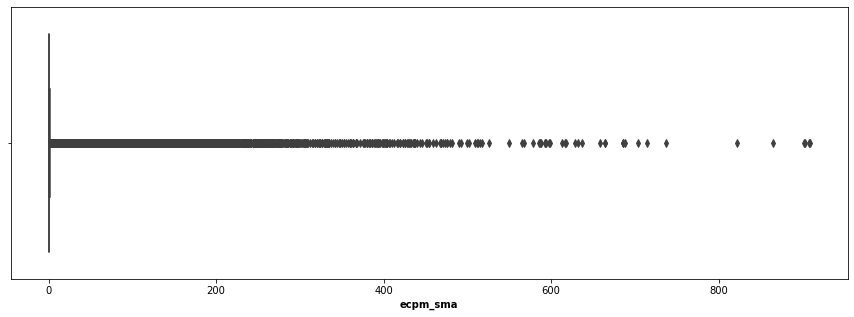

In [ ]:
plt.figure(figsize = (15, 5))
sns.boxplot(x = 'ecpm_sma', data = df_)
plt.show()

In [ ]:
q1  = df_.ecpm_sma.quantile(0.25)
q3  = df_.ecpm_sma.quantile(0.75)
iqr = q3 - q1  
lower_bound  = q1 - (1.5 * iqr) 
higher_bound = q3 + (1.5 * iqr)

# датафрейм без выбросов:
df_new = df_.loc[df_.ecpm_sma.between(lower_bound, higher_bound, inclusive = 'both')]

In [ ]:
df_.ecpm_sma.describe() # с выбросами

count    860079.000000
mean          3.147110
std          15.973978
min           0.001014
25%           0.139942
50%           0.480991
75%           0.772006
max         908.876160
Name: ecpm_sma, dtype: float64

In [ ]:
df_new.ecpm_sma.describe() # без выбросов

count    715215.000000
mean          0.394522
std           0.338061
min           0.001014
25%           0.101163
50%           0.398593
75%           0.532774
max           1.720088
Name: ecpm_sma, dtype: float64

In [ ]:
df_new.info() # good

<class 'pandas.core.frame.DataFrame'>
Int64Index: 715215 entries, 0 to 860074
Data columns (total 18 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   profile_id               715215 non-null  object        
 1   os_version               715215 non-null  object        
 2   device_manufacturer      715215 non-null  object        
 3   device_model             715215 non-null  object        
 4   device_type              715215 non-null  object        
 5   device_locale            715215 non-null  object        
 6   event_name               715215 non-null  object        
 7   event_datetime           715215 non-null  datetime64[ns]
 8   event_timestamp          715215 non-null  int64         
 9   event_receive_datetime   715215 non-null  datetime64[ns]
 10  event_receive_timestamp  715215 non-null  int64         
 11  connection_type          715215 non-null  object        
 12  operator_name   

#**Анализ данных**

Для **каждого** формата рекламы требуется:
* построить распределение средних eCPM-ов юзеров;
* построить распределение eCPM-ов по городам, версиям ОС;
* построить распределение доходов по городам, версиям ОС
* **eCPM** – доход за 1000 показов рекламы.
---



In [ ]:
def time_period(row):
    # время просмотра рекламы в игре пользователем   
    return row['event_receive_datetime'] - row['event_datetime']

In [ ]:
# добавим новый столбец со временем, затраченным пользователем на просмотр рекламы:

df_new['time_period'] = df_new.apply(time_period, axis = 1) 

display(df_new.sort_values('time_period', ascending = True).head(3))
display(df_new.sort_values('time_period', ascending = True).tail(3))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,profile_id,os_version,device_manufacturer,device_model,device_type,device_locale,event_name,event_datetime,event_timestamp,event_receive_datetime,event_receive_timestamp,connection_type,operator_name,country_iso_code,city,ad_type,view_index,ecpm_sma,time_period
151381,JMER7X7qTJR,11,Samsung,Galaxy A51,phone,en_US,c_ad_revenue,2022-02-07 00:14:38,1644182078,2022-02-07 00:13:23,1644182003,cell,AT&T,US,New York,banner,0,0.315574,-1 days +23:58:45
732444,JMER7X7qTJR,11,Samsung,Galaxy A51,phone,en_US,c_ad_revenue,2022-02-06 23:50:42,1644180642,2022-02-06 23:49:27,1644180567,cell,AT&T,US,New York,banner,0,0.449871,-1 days +23:58:45
732476,JMER7X7qTJR,11,Samsung,Galaxy A51,phone,en_US,c_ad_revenue,2022-02-06 23:56:27,1644180987,2022-02-06 23:55:12,1644180912,cell,AT&T,US,New York,banner,0,0.442864,-1 days +23:58:45


,profile_id,os_version,device_manufacturer,device_model,device_type,device_locale,event_name,event_datetime,event_timestamp,event_receive_datetime,event_receive_timestamp,connection_type,operator_name,country_iso_code,city,ad_type,view_index,ecpm_sma,time_period
802349,JLM2bnoC8BU,10,Samsung,Galaxy S9+,phone,en_US,c_ad_revenue,2022-01-30 01:45:59,1643496359,2022-02-05 20:28:54,1644082134,wifi,AT&T,US,New York,banner,0,0.324576,6 days 18:42:55
802348,JLM2bnoC8BU,10,Samsung,Galaxy S9+,phone,en_US,c_ad_revenue,2022-01-30 01:45:44,1643496344,2022-02-05 20:28:54,1644082134,wifi,AT&T,US,New York,banner,0,0.327306,6 days 18:43:10
802347,JLM2bnoC8BU,10,Samsung,Galaxy S9+,phone,en_US,c_ad_revenue,2022-01-30 01:45:29,1643496329,2022-02-05 20:28:54,1644082134,wifi,AT&T,US,New York,banner,0,0.330340,6 days 18:43:25


In [ ]:
df_new.shape

(715215, 19)

In [ ]:
# уберем из датафрейма нефизичные отрицательные временные промежутки:
df_new = df_new.loc[df_new.time_period.dt.days != -1]
df_new.shape

# удалили, таким образом, 9361 строк с отрицательным временем просмотра рекламы

(705854, 19)

**Число уникальных пользователей, которые смотрели рекламу, в зависимости от её формата и затраченное на её просмотр время:**

In [ ]:
display(df_new.groupby('ad_type').agg({'profile_id': 'nunique', 'time_period': 'sum'}).reset_index())

print("\nСуммарное время, затраченное всеми пользователями на данную игру, составило "
      f"целых {df_new.groupby('ad_type')['time_period'].sum()[0].days} дня.")

,ad_type,profile_id,time_period
0,banner,3030,4942 days 01:53:29
1,int,6,1 days 11:17:25
2,rv,1,0 days 00:03:38



Суммарное время, затраченное всеми пользователями на данную игру, составило целых 4942 дня.


В итоге видим, что пользователи **не** особо интересовались **полноэкранной** рекламой (суммарно всего 6 человек потратило менее двух дней времени на её просмотр), и **всего один (!)** пользователь потратил **менее 5 минут (!)** своего времени на просмотр рекламы по желанию.

* Таким образом, пользователи данной мобильной игры совершенно **не заинтересованы** в просмотре рекламы формата **"rv"**.
* Видимо, их не интересуют те игровые монетки или др. ресурсы, которые они могут получить за её просмотр.
* **Вывод:** данный тип рекламы желательно полностью заменить/вовсе убрать, либо изменить тип игровой монетизации за просмотр.

---

Иными словами, это **негативно** скажется на доходе игры от просмотра полноэкранной рекламы и рекламы по желанию.

Рассмотрим эти доходы:

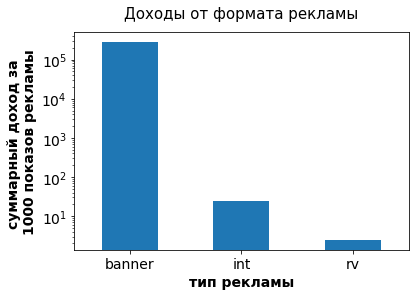


Действительно, основной доход разработчики игры получают только от неотключаемой рекламы в виде баннера.


In [ ]:
df_new.groupby('ad_type')['ecpm_sma'].sum().plot.bar(logy = True, rot = 0)
plt.xlabel('тип рекламы')
plt.ylabel('суммарный доход за \n1000 показов рекламы')
plt.title('Доходы от формата рекламы')
plt.show()
print('\nДействительно, основной доход разработчики игры получают только от неотключаемой рекламы в виде баннера.')

**Распределение доходов eCPM по городам**

In [ ]:
df_new.country_iso_code.unique() # т.е. все представленные города находятся в США

array(['US'], dtype=object)

In [ ]:
df_city = df_new.groupby(['ad_type', 'city']).agg({'ecpm_sma': 'sum'}).sort_values('ecpm_sma', ascending = False).reset_index()

df_city.head(10).style.background_gradient(cmap = 'YlOrRd')

,ad_type,city,ecpm_sma
0,banner,New York,111308.116193
1,banner,Minneapolis,4574.704903
2,banner,Springfield,4126.726945
3,banner,Charlotte,3559.444333
4,banner,Houston,3189.551805
5,banner,Indianapolis,2513.948125
6,banner,Columbus,2456.399298
7,banner,Denver,2382.761492
8,banner,Dallas,2372.886163
9,banner,Chicago,2285.598837


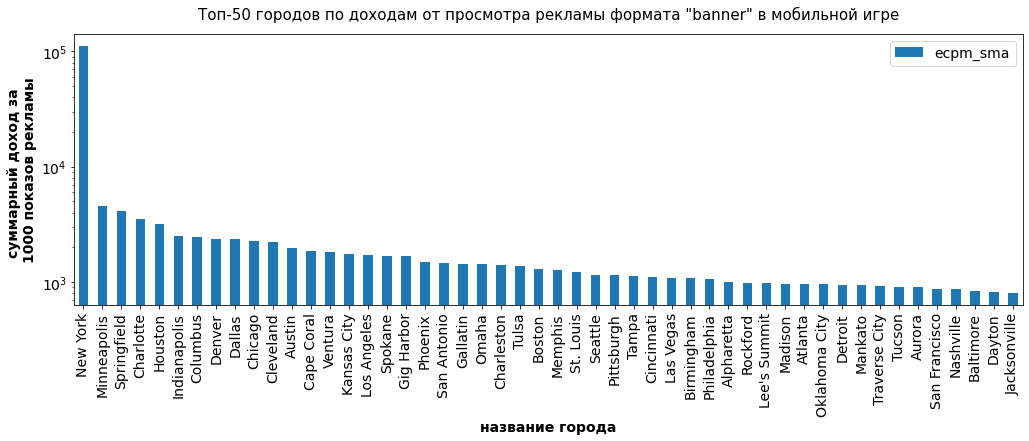

На первом месте c большим отрывом по доходам от рекламы формата "banner" занимает город Нью-Йорк.


In [ ]:
df_city.loc[df_city.ad_type == 'banner'].head(50).\
plot.bar(x = 'city', y = 'ecpm_sma', figsize = (17,5), logy = True,
         xlabel = 'название города',
         ylabel = 'суммарный доход за \n1000 показов рекламы',
         title  = 'Топ-50 городов по доходам от просмотра рекламы формата "banner" в мобильной игре')
plt.show()

print('На первом месте c большим отрывом по доходам от рекламы формата "banner" занимает город Нью-Йорк.')

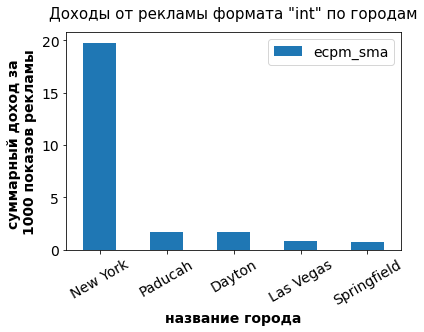

Видим, что город Нью-Йорк снова лидирует по доходам от полноэкранной рекламы в игре.


In [ ]:
df_city.loc[df_city.ad_type == 'int'].plot.bar(x = 'city', y = 'ecpm_sma', rot = 30)
plt.xlabel('название города')
plt.ylabel('суммарный доход за \n1000 показов рекламы')
plt.title('Доходы от рекламы формата "int" по городам')
plt.show()

print('Видим, что город Нью-Йорк снова лидирует по доходам от полноэкранной рекламы в игре.')

In [ ]:
print('График для формата рекламы "rv" строить не будем ввиду получения компанией рекламного дохода \nлишь от единственного пользователя, \
который смотрел рекламу по своему желанию.\n')

display(df_city.loc[df_city.ad_type == 'rv'])

print('\nДанные этого пользователя снова из города Нью-Йорка:\n')
df_new[['profile_id', 'os_version', 'device_manufacturer', 'device_type', 'ad_type', 'city', 'ecpm_sma']].loc[df_new.ad_type == 'rv']

График для формата рекламы "rv" строить не будем ввиду получения компанией рекламного дохода 
лишь от единственного пользователя, который смотрел рекламу по своему желанию.



,ad_type,city,ecpm_sma
727,rv,New York,2.462408



Данные этого пользователя снова из города Нью-Йорка:



,profile_id,os_version,device_manufacturer,device_type,ad_type,city,ecpm_sma
3521,JL3xP8xM4Xf,9,Samsung,phone,rv,New York,0.686281
3523,JL3xP8xM4Xf,9,Samsung,phone,rv,New York,0.628739
3524,JL3xP8xM4Xf,9,Samsung,phone,rv,New York,0.592601
3528,JL3xP8xM4Xf,9,Samsung,phone,rv,New York,0.554788


**Распределение доходов eCPM по версиям операционной системы**

In [ ]:
df_os = df_new.groupby(['ad_type', 'os_version'])['ecpm_sma'].sum().sort_values(ascending = False).reset_index()
df_os.style.background_gradient(cmap = 'YlOrRd')

,ad_type,os_version,ecpm_sma
0,banner,12,144792.729766
1,banner,11,58462.711854
2,banner,10,48824.318006
3,banner,9,20285.983402
4,banner,8.1.0,2539.127943
5,banner,8.0.0,2177.056983
6,banner,7.0,977.679463
7,banner,7.1.1,290.809614
8,banner,7.1.2,249.307872
9,banner,6.0.1,152.636229


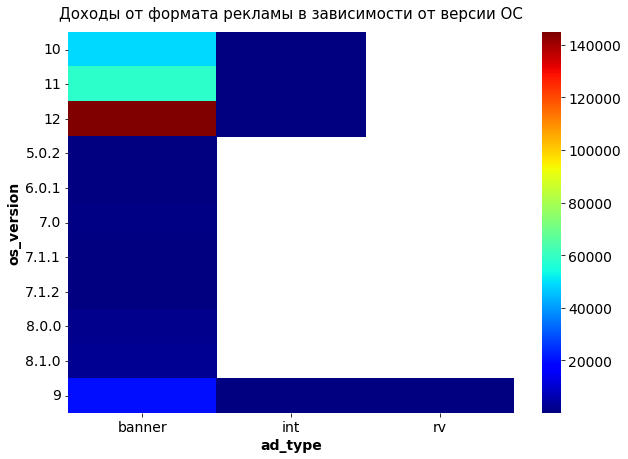

In [ ]:
# Представим данные доходов по формату рекламы от версии ОС в виде сводной таблицы и тепловой карты:
plt.figure(figsize = (10, 7))

pivot_os = pd.pivot_table(df_os, index = 'os_version', columns = 'ad_type', values = 'ecpm_sma')

sns.heatmap(pivot_os, cmap = 'jet')
plt.title('Доходы от формата рекламы в зависимости от версии ОС')
plt.show()

* Больше всего доходов компания получает от пользователей с версией операционной системы равной **12** для формата рекламы "**banner**".
* Пользователи с **этой же** версией ОС приносят компании больше всего доходов от просмотра **полноэкранной** рекламы.
* Пользователь со смартфоном Samsung с установленной **os_version = 9** смотрел рекламу по своему желанию.   
* **Вывод:** в эту мобильную игру чаще всего играют люди с устройств на последней версии ОС.

**Распределение доходов eCPM по производителям мобильных устройств**

> 1. Смартфоны



In [ ]:
df_phone = df_new.loc[df_new.device_type == 'phone'].groupby(['ad_type', 'device_manufacturer'])\
           ['ecpm_sma'].sum().sort_values(ascending = False).reset_index()

df_phone.head(10).style.background_gradient(cmap = 'YlOrRd')

,ad_type,device_manufacturer,ecpm_sma
0,banner,Samsung,207863.615034
1,banner,Google,26334.897800
2,banner,Motorola,17060.042819
3,banner,LG,10894.280707
4,banner,OnePlus,3150.492805
5,banner,T-Mobile,1429.175740
6,banner,Dish,678.131387
7,banner,Kyocera,677.959185
8,banner,TCL,584.785131
9,banner,Alcatel,498.720208


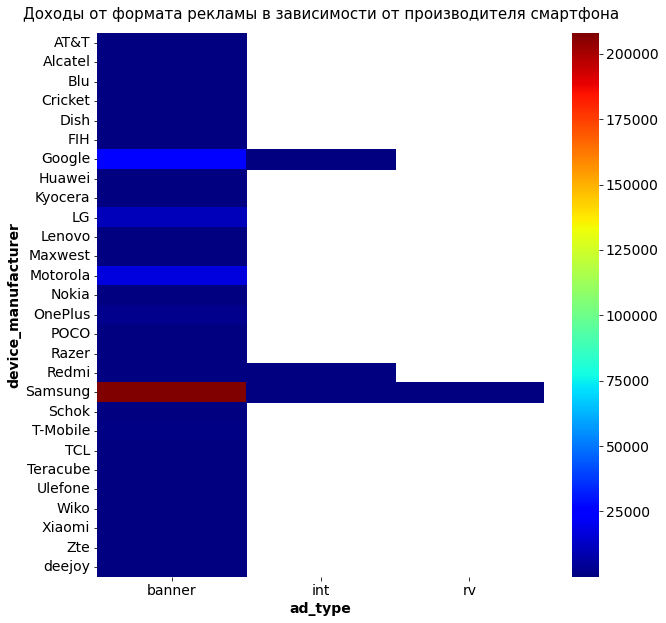

In [ ]:
plt.figure(figsize = (10, 10))

pivot_device_phone = pd.pivot_table(df_phone, index = 'device_manufacturer', columns = 'ad_type', values = 'ecpm_sma')
sns.heatmap(pivot_device_phone, cmap = 'jet')

plt.title('Доходы от формата рекламы в зависимости от производителя смартфона')
plt.show()

**Вывод:** 
* пользователи на смартфонах от производителя **Samsung** больше всего генерируют доходы через игру **вне зависимости** от формата просмотренной ими рекламы, на втором месте - от **Google**, на третьем - от **Motorola**;
* мобильная игра, видимо, **не** разрабатывалась для устройств компании Apple (т.е., возможно, теряется **значимая** доля игрового рынка). 

**Распределение доходов eCPM по производителям мобильных устройств**

> 2. Планшеты

In [ ]:
df_tablet = df_new.loc[df_new.device_type == 'tablet'].groupby(['ad_type', 'device_manufacturer'])['ecpm_sma'].sum().sort_values(ascending = False).reset_index()
df_tablet.style.background_gradient(cmap = 'YlOrRd')

,ad_type,device_manufacturer,ecpm_sma
0,banner,Samsung,6515.327849
1,banner,Google,593.288895
2,banner,JOYAR,119.364104
3,banner,Lenovo,109.897679
4,banner,OnePlus,59.110960
5,banner,Verizon Wireless,42.574073
6,banner,Onn (Walmart),20.155221
7,banner,Motorola,3.405273
8,int,Samsung,0.862078
9,banner,AEEZO,0.186172


**Наибольший** доход eCPM разработчики игры получают от пользователей с планшетами также от компании **Samsung** для формата рекламы "**banner**", а на втором месте уже от **Google**.

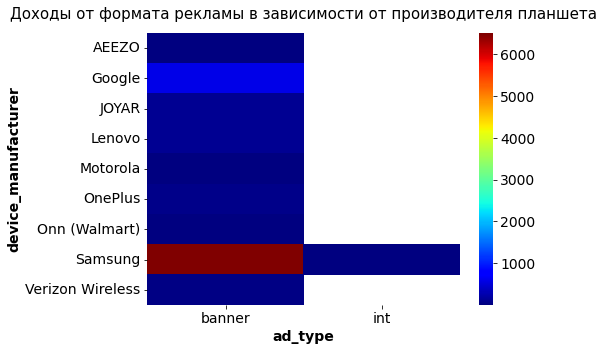

In [ ]:
plt.figure(figsize = (7, 5))

pivot_device_tablet = pd.pivot_table(df_tablet, index = 'device_manufacturer', columns = 'ad_type', values = 'ecpm_sma')
sns.heatmap(pivot_device_tablet, cmap = 'jet')

plt.title('Доходы от формата рекламы в зависимости от производителя планшета')
plt.show()

In [ ]:
print(f'Суммарные доходы от игр на смартфонах: {int(df_phone.ecpm_sma.sum())}.')
print(f'Суммарные доходы от игр на планшетах:  {int(df_tablet.ecpm_sma.sum())}.')
print(f'Таким образом, рекламные доходы от данной игры на смартфонах в {int(df_phone.ecpm_sma.sum()/df_tablet.ecpm_sma.sum())} раз \
превосходят доходы от игры на планшетах.')

Суммарные доходы от игр на смартфонах: 271458.
Суммарные доходы от игр на планшетах:  7464.
Таким образом, рекламные доходы от данной игры на смартфонах в 36 раз превосходят доходы от игры на планшетах.


**Зависит ли рекламный доход компании от времени суток?**

In [ ]:
# добавим номера часов:
df_new['hour'] = df_new.event_datetime.dt.hour

df_hour = df_new.groupby(['ad_type', 'hour'])['ecpm_sma'].sum().sort_values(ascending = False).reset_index()
df_hour.head(10).style.background_gradient(cmap = 'YlOrBr')

,ad_type,hour,ecpm_sma
0,banner,5,18225.404051
1,banner,4,17557.739863
2,banner,3,17211.193194
3,banner,6,16461.911893
4,banner,2,15929.496722
5,banner,7,14869.431127
6,banner,1,14696.574791
7,banner,0,14686.168323
8,banner,22,14566.007794
9,banner,23,14502.959709


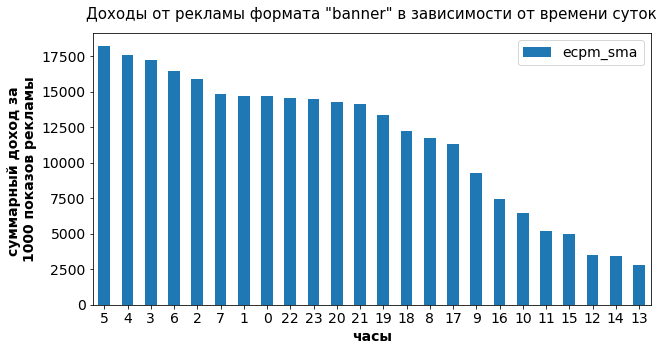

In [ ]:
df_hour.loc[df_hour.ad_type == 'banner'].plot.bar(figsize = (10, 5), x = 'hour', y = 'ecpm_sma', rot = 0)
plt.xlabel('часы')
plt.ylabel('суммарный доход за \n1000 показов рекламы')
plt.title('Доходы от рекламы формата "banner" в зависимости от времени суток')
plt.show()

Видим, что **наибольшие** доходы от показа рекламы формата "**banner**" компания получает в **утренние** часы, а **меньше** всего дохода от такого формата рекламы - в **обеденное** время.

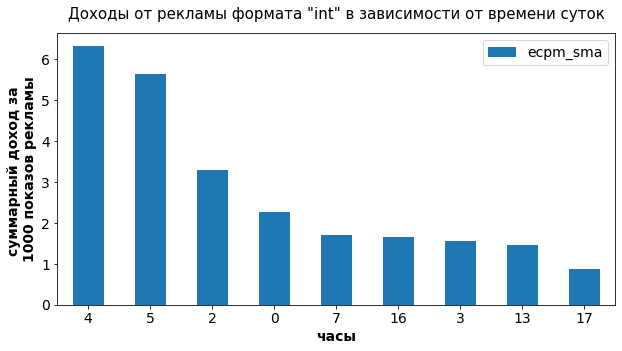

In [ ]:
df_hour.loc[df_hour.ad_type == 'int'].plot.bar(figsize = (10, 5), x = 'hour', y = 'ecpm_sma', rot = 0)
plt.xlabel('часы')
plt.ylabel('суммарный доход за \n1000 показов рекламы')
plt.title('Доходы от рекламы формата "int" в зависимости от времени суток')
plt.show()

* **Наибольшие** доходы от показа **полноэкранной** рекламы компания получает в 4-5 утра, а **меньше** всего дохода компания - в 17 часов вечера.
* Эти доходы в любое время суток на **порядки меньше** доходов от горизонтального баннера.

In [ ]:
df_new.device_locale.unique() # языки мобильных устройств пользователей

array(['en_US', 'en_GB', 'en_NL', 'ko_KR', 'fr_FR', 'en_CA', 'en_IN',
       'en_AU'], dtype=object)

Видим, что в стране США у пользователей локализация мобильных устройств различная.

Поэтому выясним, какое имеется **распределение рекламных доходов в зависимости от локализации устройств, с которых играют пользователи**.

In [ ]:
df_locale = df_new.groupby(['ad_type', 'device_locale'])['ecpm_sma'].sum().sort_values(ascending = False).reset_index()
df_locale.style.background_gradient(cmap = 'YlOrBr')

,ad_type,device_locale,ecpm_sma
0,banner,en_US,278084.839867
1,banner,en_IN,257.547561
2,banner,en_GB,239.122034
3,banner,en_CA,148.442189
4,banner,ko_KR,88.229003
5,banner,en_NL,59.767178
6,int,en_US,18.430752
7,banner,fr_FR,8.754692
8,banner,en_AU,8.494522
9,int,en_GB,6.317599


* Видим, что **наибольший суммарный** доход от рекламы зарабатывает игра на устройствах с **американским английским**. 
* Это кажется очевидным, т.к. все представленные города, с которых пользователи заходили в игру, находятся в США.
* Поэтому далее **исключим** американский английский из рассмотрения, т.к. нам важно понимать, на какие другие языки надо обращать внимание при дальнейшей локализации мобильного приложения.

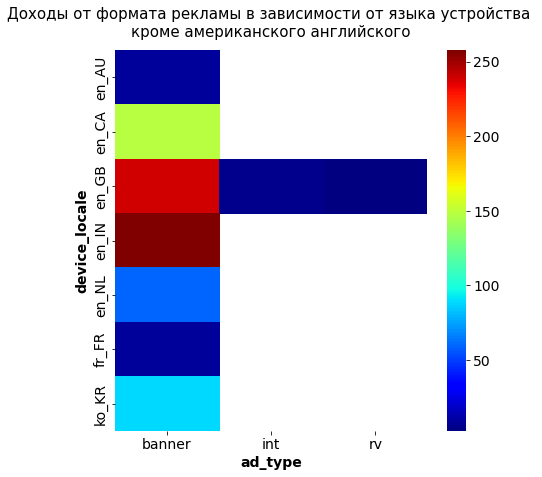

In [ ]:
plt.figure(figsize = (7, 7))

pivot_device_locale = pd.pivot_table(df_locale.loc[df_locale.device_locale != 'en_US'], 
                                     index = 'device_locale', columns = 'ad_type', values = 'ecpm_sma')
sns.heatmap(pivot_device_locale, cmap = 'jet')

plt.title('Доходы от формата рекламы в зависимости от языка устройства \nкроме американского английского')
plt.show()

На **втором** месте после американского английского пользователи на устройствах с локализацией "**английский (Индия)**" больше всего смотрят рекламу формата "**banner**" в игре. А на третьем месте - с локализацией "**британский английский**".

Информации по локализации игрового приложения на китайский язык, однако, **не** представлено в исходных данных.

**А какие пользователи игры самые активные?**

In [ ]:
print(f'Найдем, например, 20 из {df_new.profile_id.nunique()} уникальных пользователей, кто больше всего посмотрел встроенной рекламы.')

Найдем, например, 20 из 3030 уникальных пользователей, кто больше всего посмотрел встроенной рекламы.


In [ ]:
df_profile_id = df_new.groupby(['ad_type', 'profile_id'])['ecpm_sma'].sum().sort_values(ascending = False).reset_index()
df_profile_id.head(20).style.background_gradient(cmap = 'YlOrBr')

,ad_type,profile_id,ecpm_sma
0,banner,JL5pmKYe8g7,3501.360013
1,banner,JLjpdpniiny,1775.909998
2,banner,JL4KSxxKnjo,1734.828578
3,banner,JL4p0t068V1,1575.142983
4,banner,JLkavQUMeHc,1484.996926
5,banner,JLTfZhBE0e3,1450.474102
6,banner,JLiWhxNu122,1404.071839
7,banner,JLw5cKeZSby,1317.800508
8,banner,JLjXBdxPBjg,1211.009752
9,banner,JLnrqVfS2Fn,1204.702705


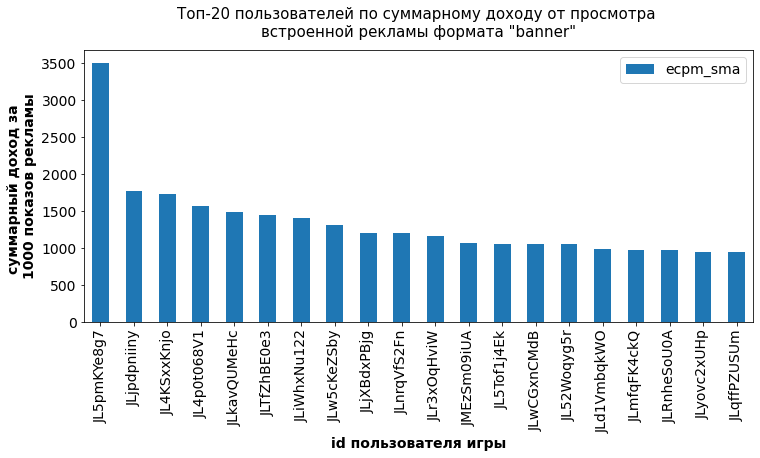

In [ ]:
df_profile_id.loc[df_profile_id.ad_type == 'banner'].head(20).plot.bar(figsize = (12, 5), x = 'profile_id', y = 'ecpm_sma')
plt.xlabel('id пользователя игры')
plt.ylabel('суммарный доход за \n1000 показов рекламы')
plt.title('Топ-20 пользователей по суммарному доходу от просмотра \nвстроенной рекламы формата "banner"')
plt.show()

In [ ]:
print(f'Пользователь с id "{df_profile_id.profile_id.loc[0]}" самый активный в игре.')

Пользователь с id "JL5pmKYe8g7" самый активный в игре.


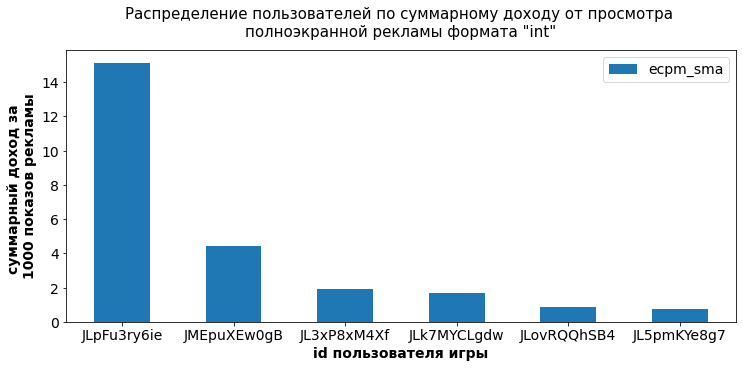

In [ ]:
df_profile_id.loc[df_profile_id.ad_type == 'int'].plot.bar(figsize = (12, 5), x = 'profile_id', y = 'ecpm_sma', rot = 0)
plt.xlabel('id пользователя игры')
plt.ylabel('суммарный доход за \n1000 показов рекламы')
plt.title('Распределение пользователей по суммарному доходу от просмотра \nполноэкранной рекламы формата "int"')
plt.show()